# RNAseq data parsing. 

## Data 

### Gene locus -> Kegg pathways 
Generated using Kegg's own Kofam Koala tool. It requires fasta protein files that can be generated from this script. 

### RNAseq
The data is DESeq2's Logarithmic Fold Change Estimate (LFC). Which
is the result of a statistical model that shrink the ratio
treatment/control (normalised read count) toward 0 (and shrink more when
information about a gene is low) to increase the reliability of
comparisons (cf the article https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8).

All the comparison I used where `Nz13<sugar>` vs `Nz13<delmutant><sameSugar>`. 

As far as I can tell from the data that I got, all the comparison where
sent to me with `Nz13<sugar>` as the treatment and
`Nz13<delmutant><sameSugar>` as control.

Thus a positive LFC means that the read count is higher in `Nz13<sugar>`
(the wild type of NZ13) than in `Nz13<delmutant><sameSugar>` (the mutant
with a deletion).

In other words, a positive (green) value mean that Tn (or whatever was
deleted) has a "positive" effect on the locus' expression.

## svg pathways with cytoscape. 

The notebook uses py2cytoscape to generate graphs of the pathways, color them and add barplots drawn with matplotlib. In order for this to work: 

- cytoscape must be running with the keggscape extension (to be able to parse the keggml files). 
- the barplot must be accessible to cytoscape in http. I start `python3 -m http.server 8012` in another console to serve the folder in which they are generated. Use the LOCALHOST constant if you want to change it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from IPython.display import display, HTML
from Bio import SeqIO
from itertools import chain
import os
import glob
import re
from collections import defaultdict
import pickle as pkle
import matplotlib.pyplot as plt

sugars = ('glucose','succinate','citrate')
mutants = ('ΔTn6212','Δ3','ΔLysR','ΔdctT')
coherances_nest = {
    'removed lysR':('ΔLysR','ΔTn6212','Δ3'),
    'removed dctT':('ΔTn6212','ΔdctT'),
    'removed cata or lipo':('ΔTn6212','Δ3')
}

# --- FILES ---
# (Received from E. Colombi 20191213)
GB_CHROMOSOME = "data/raw/PsaNZ13_genebank.gb"
GB_PLASMID = "data/raw/PsaNZ13_plasmid_genebank.gb"
# from pseudomonas.com (20191211)
PSEUDO_DB = 'data/raw/Pseudomonas_syringae_pv_actinidiae_ICMP_18884_7747.csv'
# mapped NZ13 on KEGGdb using https://www.genome.jp/tools/kofamkoala/
KOFAM_KOALA = 'data/kofam_koala.txt'
KOFAM_KOALA_PLASMID = 'data/kofam_koala_plasmid.txt'
# Retreived annotation from KEGG api (code below to recreate)
KEGG_DB_LOCAL = 'data/raw/kegg_annotation.pkle'
# RNASEQ data (Received from E. Colombi)
RNASEQ_DATA_GLOB = 'data/raw/200109_raw_rnaseq_comparison/deseq2/**/*.txt'
PVAL_THRESHOLD = 0.05
VALUE_COL = 'log2FoldChange'

# Usefull library for SVG panning and zooming. 
PAN_ZOOM_LOCAL = 'lib/svg-pan-zoom.min.js'
PAN_ZOOM_URL = "https://raw.githubusercontent.com/ariutta/svg-pan-zoom/master/dist/svg-pan-zoom.min.js"

from py2cytoscape.data.cyrest_client import CyRestClient
import py2cytoscape.cyrest.view
from py2cytoscape import cyrest
import xml.dom.minidom
import re
import json
KEGG_PATHWAYS_GLOB = 'data/kegg/maps/*.xml'
KEGG_HTML_OUTPUT = 'www/kegg'
LOCALHOST = 'http://localhost:8012/'
EXPRESSION_GRAPHS_OUT = os.path.join(KEGG_HTML_OUTPUT, 'graphs/')
if not os.path.exists(KEGG_HTML_OUTPUT):
    os.mkdir(KEGG_HTML_OUTPUT)
if not os.path.exists(EXPRESSION_GRAPHS_OUT):
    os.mkdir(EXPRESSION_GRAPHS_OUT)

libigraph.so.0: cannot open shared object file: No such file or directory
py2cytoscape: Error importing igraph. You won't be able to import from igraph.


In [2]:
!rm rnaseq.log
import logging
import time

logger = logging.getLogger('rnaseq')

formatter = logging.Formatter('%(levelname)s: %(message)s')

# Setup file handler
fhandler  = logging.FileHandler('rnaseq.log')
fhandler.setLevel(logging.DEBUG)
fhandler.setFormatter(formatter)

# Configure stream handler for the cells
chandler = logging.StreamHandler()
chandler.setLevel(logging.DEBUG)
chandler.setFormatter(formatter)

# Add both handlers
logger.handlers.clear()
logger.addHandler(fhandler)
logger.addHandler(chandler)
logger.setLevel(logging.DEBUG)
logger.info('Script run at {}'.format(time.strftime('%X %x %Z')))

INFO: Script run at 14:23:57 01/27/20 CET


In [3]:
# Load the RNAseq data 
logger.info('Load RNAseq data. (Using {})'.format(VALUE_COL))
data = {}
total = []
aset, bset = set(), set()
data_origin = []
for file in glob.glob(RNASEQ_DATA_GLOB):
    bname = os.path.basename(file)
    if not 'raw' in bname:
        a,_,b = bname.split('.')[0].split('_')
        sugars_translate = {'suc':'succinate', 'glu':'glucose', 'cit':'citrate'}
        mut_a, sugar_a = re.sub('^d','Δ',a[4:-3]), sugars_translate[a[-3:]]
        mut_b, sugar_b = re.sub('^d','Δ',b[4:-3]), sugars_translate[b[-3:]]
        origin = 'plasmid' if 'plasmid' in file else 'chromosome'
        data[(mut_a,sugar_a,origin),(mut_b,sugar_b,origin)] = pd.read_csv(file, sep=' ')
        if not mut_a:
            dt = data[(mut_a,sugar_a,origin),(mut_b,sugar_b,origin)].loc[:, [VALUE_COL,'pvalue']]
            logger.info('Load {1} lines from {0}'.format(file, dt.shape[0]))
            dt['ref'] = mut_a+('_' if mut_a else '')+sugar_a
            dt['sample'] = mut_b+'_'+sugar_b
            dt['origin'] = origin
            total.append(dt.copy())
total = pd.concat(total)
logger.info('{} entries'.format(total.shape[0]))

data = pd.pivot(total, columns='sample', values=VALUE_COL)
pval = pd.pivot(total, columns='sample', values='pvalue')

logger.info('{} Genes'.format(data.shape))
idx = pval.fillna(1).min(1)<=PVAL_THRESHOLD
data = data.loc[idx]
pval = pval[idx]
logger.info('{} Genes after filtering (pval<{})'.format(data.shape,PVAL_THRESHOLD ))
colnames = list(chain(*[['{}_{}'.format(m,s) for m in mutants] for s in sugars]))
data = data[colnames]
pval = pval[colnames]
data.to_csv('data/rnaseq_foldchange_WTcompare_pval{}.csv'.format(str(PVAL_THRESHOLD).replace('.','')))

INFO: Load RNAseq data. (Using log2FoldChange)
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13suc_vs_NZ13d3suc.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13cit_vs_NZ13d3cit.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13suc_vs_NZ13dTn6212suc.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13glu_vs_NZ13ddctTglu.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13glu_vs_NZ13dLysRglu.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13glu_vs_NZ13dTn6212glu.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13cit_vs_NZ13dLysRcit.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13cit_vs_NZ13ddctTcit.txt
INFO: Load 81 lines from data/raw/200109_raw_rnaseq_comparison/deseq2/plasmid/NZ13suc_vs_NZ13ddctTsuc.txt
I

In [4]:
# Load Genome
logger.info('Load sequences data')

gb_chromosome = list(SeqIO.parse(open(GB_CHROMOSOME,"r"), "genbank"))[0]
gb_plasmid = list(SeqIO.parse(open(GB_PLASMID,"r"), "genbank"))[0]

# Get genes on the chromosome and plasmid
genes_chromosome = {f.qualifiers['locus_tag'][0] for f in gb_chromosome.features if f.type=="gene"}
genes_plasmid = {f.qualifiers['locus_tag'][0] for f in gb_plasmid.features if f.type=="gene"}
assert not genes_chromosome.intersection(genes_plasmid) # No genes are in common. 

logger.info('Load {1} entries from {0}'.format(GB_CHROMOSOME, len(genes_chromosome)))
logger.info('Load {1} entries from {0}'.format(GB_PLASMID, len(genes_plasmid)))

# Map protein ids
prot_id = {f.qualifiers['protein_id'][0]:f.qualifiers['locus_tag'][0] for f in gb_chromosome.features if f.type=="CDS"}

INFO: Load sequences data
INFO: Load 5883 entries from data/raw/PsaNZ13_genebank.gb
INFO: Load 84 entries from data/raw/PsaNZ13_plasmid_genebank.gb


In [5]:
# Export for KOFAM-koala
# KOFAM-koala wants protein fasta files. 
for path,gb in ((GB_CHROMOSOME,gb_chromosome),(GB_PLASMID,gb_plasmid)):
    new_path = path.replace('.gb','_protein.fasta')
    if not os.path.exists(new_path):
        output = []
        for feat in gb.features:
            if 'translation' in feat.qualifiers:
                output.append('>{} \n{}'.format(feat.qualifiers['locus_tag'][0], feat.qualifiers['translation'][0]))

        with open(new_path,'w') as file:
            file.write('\n'.join(output))
        logger.info('Convert {} entries to protein fasta ({}).'.format(len(output), new_path))

In [6]:
# Load reference annotation
pseudo = pd.read_csv(PSEUDO_DB)
pseudo = pseudo.set_index('Gene synonyns')
logger.info('Loaded {} genes description from {}'.format(pseudo.shape[0], PSEUDO_DB))
pseudo.head()

INFO: Loaded 5974 genes description from data/raw/Pseudomonas_syringae_pv_actinidiae_ICMP_18884_7747.csv


DB Version Assembly Accession Chromosome/Plasmid Name  \
Gene synonyns                                                          
IYO_000005           19.1    GCF_000648735.2              chromosome   
IYO_000010           19.1    GCF_000648735.2              chromosome   
IYO_000015           19.1    GCF_000648735.2              chromosome   
IYO_000020           19.1    GCF_000648735.2              chromosome   
IYO_000025           19.1    GCF_000648735.2              chromosome   

              Chromosome/Plasmid Xref  PGD Gene ID    Locus Tag Feature Type  \
Gene synonyns                                                                  
IYO_000005              NZ_CP011972.1  PGD88726915  IYO_RS00005          CDS   
IYO_000010              NZ_CP011972.1  PGD88726917  IYO_RS00010          CDS   
IYO_000015              NZ_CP011972.1  PGD88726919  IYO_RS00015          CDS   
IYO_000020              NZ_CP011972.1  PGD88726921  IYO_RS00020          CDS   
IYO_000025              NZ_CP011972.1  PGD88726923  IYO_RS00025          CDS   

               Start   End Strand Gene Name  \
Gene synonyns                                 
IYO_000005       102  1637      +       NaN   
IYO_000010      1676  2779      +       NaN   
IYO_000015      2802  3905      +       NaN   
IYO_000020      3910  6327      +      gyrB   
IYO_000025      6593  8194      +       NaN   

                                                  Product Name  \
Gene synonyns                                                    
IYO_000005     chromosomal replication initiation protein DnaA   
IYO_000010                     DNA polymerase III subunit beta   
IYO_000015                      DNA recombination protein RecF   
IYO_000020                                DNA gyrase subunit B   
IYO_000025                               DNA methyltransferase   

               Product Name Confidence Class  Product Synonyms  \
Gene synonyns                                                    
IYO_000005                               NaN               NaN   
IYO_000010                               NaN               NaN   
IYO_000015                               NaN               NaN   
IYO_000020                               NaN               NaN   
IYO_000025                               NaN               NaN   

              RefSeq Accession  Length (nucleotides)  Length (amino acids)  \
Gene synonyns                                                                
IYO_000005      WP_003377875.1                  1536                 511.0   
IYO_000010      WP_003377873.1                  1104                 367.0   
IYO_000015      WP_003377871.1                  1104                 367.0   
IYO_000020      WP_003377870.1                  2418                 805.0   
IYO_000025      WP_017683408.1                  1602                 533.0   

               Molecular Weight (predicted)  Isoelectric Point (predicted)  \
Gene synonyns                                                                
IYO_000005                             57.2                           8.89   
IYO_000010                             40.7                           4.89   
IYO_000015                             41.6                           8.50   
IYO_000020                             90.1                           5.93   
IYO_000025                             59.6                           4.94   

              Subcellular Localization [Confidence Class]  
Gene synonyns                                              
IYO_000005                          Cytoplasmic [Class 3]  
IYO_000010                          Cytoplasmic [Class 3]  
IYO_000015                          Cytoplasmic [Class 3]  
IYO_000020                          Cytoplasmic [Class 3]  
IYO_000025                              Unknown [Class 3]

In [7]:
# Load KOFAM-KOALA DATA
kegg = pd.read_table(KOFAM_KOALA, index_col=False, usecols=[1,2,3,4,5], skipinitialspace=True, sep=' ', skiprows=[1])
logger.info('Loaded {} lines from {}, e-val in ({}, {})'.format(kegg.shape[0], KOFAM_KOALA, kegg['E-value'].min(), kegg['E-value'].max()))
kegg['prot'] = [x.split('prot_')[1].split('_')[0] for x in kegg.name]
kegg['locus'] = [prot_id[x] if x in prot_id else np.nan for x in kegg.prot]
kegg_pls = pd.read_table(KOFAM_KOALA_PLASMID, index_col=False, usecols=[1,2,3,4,5], skipinitialspace=True, sep=' ', skiprows=[1])
logger.info('Loaded {} lines from {}, e-val in ({}, {})'.format(kegg_pls.shape[0], KOFAM_KOALA_PLASMID, kegg_pls['E-value'].min(), kegg_pls['E-value'].max()))
kegg_pls['locus'] = kegg_pls['name']
kegg_mapping = pd.concat([kegg.drop(columns=['prot']), kegg_pls])
logger.info('{} unique mapping KO<->IYO'.format(kegg_mapping.shape[0]))

INFO: Loaded 3455 lines from data/kofam_koala.txt, e-val in (0.0, 6e-06)
INFO: Loaded 23 lines from data/kofam_koala_plasmid.txt, e-val in (5.499999999999997e-200, 1.3000000000000002e-10)
INFO: 3478 unique mapping KO<->IYO


In [8]:
# Create dictionnaries to go from KEGG to Gene locus and vice-versa. 
ko_to_iyo = kegg_mapping.loc[:,['KO','locus']].groupby('KO').locus.apply(list).to_dict()
iyo_to_ko = kegg_mapping.loc[:,['KO','locus']].groupby('locus').KO.apply(list).to_dict()

In [9]:
# Get the KEGG database entries from their API. Save the result in a pickle file locally to
# avoid requesting it each time. 
kegg_data = {}
if os.path.exists(KEGG_DB_LOCAL):
    with open(KEGG_DB_LOCAL, 'rb') as file:
        kegg_data = pkle.load(file)
missing = []
for ko in ko_to_iyo.keys():
    if ko not in kegg_data:
        missing.append(ko)
if missing:
    logger.info('{} entries are missing from local KEGG db. Retreiving...'.format(len(missing)))
    from bioservices.kegg import KEGG
    s = KEGG()
    for i,ko in enumerate(missing):
        print("{}/{} {}".format(i,len(missing),ko))
        kegg_data[ko] = s.get(ko,parse=True)
    with open(KEGG_DB_LOCAL, 'wb') as file:
        pkle.dump(kegg_data, file)

for k,v in list(kegg_data.items()):
    if v==404:
        logger.warning('Bad index {} - dropping.'.format(k))
        del kegg_data[k]
logger.info('Loaded {} KEGG entries from the local kegg database {}'.format(len(kegg_data), KEGG_DB_LOCAL))

INFO: Loaded 2337 KEGG entries from the local kegg database data/raw/kegg_annotation.pkle


In [10]:
# Parse the BRITE hierarchy from the KEGG entries. 
# Put it in a dataframe. 
def parse_brite(text, key):
    """Parse an entry from KEGG and extract BRITE feature."""
    text = text.split('[BR:ko00001]')[1]
    features = text.split('[BR:ko')[0].split('\n')[1:-1]
    prev_indent = 0
    out = []
    current = {}
    for f in features:
        if f.strip()[:len(key)] != key:
            indent = (len(f)-len(f.strip()))
            current[indent] = f.strip().split(' ',1)[1]               
            prev_indent = indent
        else:
            out.append(current.copy())
    out = pd.DataFrame(out)
    out.rename(columns= lambda x:"level_{}".format(x-out.columns.min()), inplace=True)
    out['kegg_id'] = key  
    return out

out = []
for k,v in kegg_data.items():
    try:
        out.append(parse_brite(v['BRITE'],k))
    except Exception:
        print(k)
features = pd.concat(out, sort=True)
logger.info('{} BRITE entries ({} level 0, {} level 1, {} level 3)'.format(features.shape[0], 
                                                                     features.level_0.nunique(), 
                                                                     features.level_1.nunique(),
                                                                     features.level_2.nunique()))
features.head()

INFO: 3935 BRITE entries (8 level 0, 44 level 1, 279 level 3)


kegg_id                               level_0  \
0  K02313  Environmental Information Processing   
1  K02313                    Cellular Processes   
2  K02313                     Brite Hierarchies   
3  K02313                     Brite Hierarchies   
0  K02338        Genetic Information Processing   

                                            level_1  \
0                               Signal transduction   
1                             Cell growth and death   
2  Protein families: genetic information processing   
3  Protein families: genetic information processing   
0                            Replication and repair   

                              level_2  
0                Two-component system  
1            Cell cycle - Caulobacter  
2            DNA replication proteins  
3  Chromosome and associated proteins  
0                     DNA replication

In [11]:
# Get Categories (i.e. expression motifs)

# First binarise the dataset in 3 levels: -1, 0, +1
binned = data.fillna(0)
binned.values[binned.values<0] = -1
binned.values[binned.values>0] = 1

# Associate each gene to a motif
category = {k:''.join([str(int(x)) for x in v.values]) for k,v in binned.iterrows()}
logger.info("There are unique {} expression motifs".format(len(set(category.values()))))

INFO: There are unique 894 expression motifs


In [12]:
# Sort the data. 
# Assign each expression motif some numbers. 
cat = binned.reset_index(drop=True).drop_duplicates(keep='last')
cat.fillna(0, inplace=True)
category_nb = {''.join([str(int(x)) for x in v.values]):(v.sum(),(v>0).sum(),(v<0).sum()) for i,(k,v) in enumerate(cat.iterrows())}
category_nb2 = {''.join([str(int(x)) for x in v.values]):(v.values*np.arange(1,len(v)+1)[::-1]).sum() for i,(k,v) in enumerate(cat.iterrows())}

def sorter(x):
    if x in category:
        return (category_nb[category[x]],
                category_nb2[category[x]],
                category[x],
                data.loc[x].max())
    else:
        return ((0,0,0),0,0,0)
    
idx = sorted(data.index.dropna(), reverse=True, key=sorter)
data=data.loc[idx]
for k in ko_to_iyo.keys():
    ko_to_iyo[k] = sorted(ko_to_iyo[k], key=sorter)

# Another order used only in some output. 
genome_order = sorted(data.index, key=lambda x:int(x.split('_')[1]))

In [13]:
# Some metadata. 
meta = data.copy()
meta['chromosome'] = [x in genes_chromosome for x in meta.index]
meta['plasmid'] = [x in genes_plasmid for x in meta.index]
meta['motif'] = [category[x] for x in meta.index]
meta.drop(columns=colnames, inplace=True)
meta

sample      chromosome  plasmid                     motif
IYO_024560        True    False              111111111111
IYO_012760        True    False              111111111111
IYO_025160        True    False              111111111111
IYO_014925        True    False              111111111111
IYO_006700        True    False              111111111111
...                ...      ...                       ...
IYO_026605        True    False  -1-1-1-1-1-1-1-1-1-1-1-1
IYO_005475        True    False  -1-1-1-1-1-1-1-1-1-1-1-1
IYO_005800        True    False  -1-1-1-1-1-1-1-1-1-1-1-1
IYO_011225        True    False  -1-1-1-1-1-1-1-1-1-1-1-1
IYO_019570        True    False  -1-1-1-1-1-1-1-1-1-1-1-1

[4329 rows x 3 columns]

In [14]:
head = """<!DOCTYPE html><html>
<meta charset="utf-8" /> 
<title> PSA RNAseq title_placeholder </title>
 <script src="lib/svg-pan-zoom.min.js"></script>
<style>
 table {
 width:100%;
  border-collapse: collapse;
}

td{
  border-left: 0.5px solid rgba(125,125,125,.1);
}

.sugar{
  border-left: 2px solid black;
}

tbody{
  border-top: 1px solid black;
}

/*background-color: rgba(224,88,91,0.33);*/
.mm{
background-color: rgba(217, 83, 25,0.33);
color:white;
border: 2px solid rgba(217, 83, 25);

}

.m{
background-color: rgba(224,88,91,0.15);
color:white;
}

td.mm div{
/*background-color: #e0585b;*/
background-color: rgba(217, 83, 25,1);
}

td.m div{
background-color: #EFABAD;
}


.pp{
/*background-color: rgba(89,161,78,0.33);*/
background-color: rgba(119, 172, 48,0.33);
border: 2px solid rgba(119, 172, 48);
color:white;
}

.p{
background-color: rgba(89,161,78,0.15);
color:white;
}

td.pp div{
background-color: rgba(119, 172, 48,1); /*#59a14e;*/
}

td.p div{
background-color: #bcd9b8;
}

.z{
color:white;
}

.h{
color:rgba(255,255,255,0.2);
}

.new_cat .h{
color:rgb(125,125,125);
}


.h a{
color:rgba(0,0,255,0.5);
}

.new_cat{
border-top: 1px solid black;
font-weight:bold
}

thead th{
  position: sticky;
  top: 0;
}

tr:hover
{
  background-color: rgba(0,0,0,.1);
}
</style>
"""
foot = "</body></html>"

In [15]:
def gene_locus_html(gene_locus, db=pseudo, db_kegg=kegg_data, mapping=iyo_to_ko):
    url, url_string = None, None
    name = gene_locus
    product = ''
    linker = lambda url,title,txt:('<a href="{}" title="{}">{}</a>'.format(url, title, txt) if url else '')
    plasmid = False
    html_kegg = []
    if str(k)!='nan':
        if gene_locus in db.index:
            gene = db.loc[gene_locus]
            name = gene['Gene Name'] if str(gene['Gene Name'])!='nan' else gene_locus
            product = gene['Product Name']
            plasmid = 'plasmid' in gene['Chromosome/Plasmid Name']
            url = "http://pseudomonas.com/feature/show?id={}".format(gene['PGD Gene ID'].replace('PGD',''))
        if gene_locus in mapping:
            for ko in mapping[gene_locus]:
                url_kegg = 'https://www.genome.jp/dbget-bin/www_bget?{}'.format(ko)
                title = ("{} {}".format(ko,kegg_data[ko]['DEFINITION']) 
                         if ko in db_kegg and 'DEFINITION' in kegg_data[ko]
                         else ko)
                html_kegg.append(linker(url_kegg,title,"K"))
        if  name != gene_locus:              
            url_string="https://string-db.org/network/223283/{}".format(name)
        
    html_name = '<strong>{}</strong>'.format(linker(url,gene_locus,name) if url else name)
    html_db = ''.join(html_kegg + [linker(url_string,name,'S'), 'P' if plasmid else ''])
    html_desc = product
    return html_name, html_db, html_desc

In [16]:
def row_html(key, row, columns, tr=False, pval_dset=pval):
    """Convert a row into a html table row"""
    body = []
    if tr:
        body.append('<tr>')
    for k in columns:
        val = row[k]
        if pval_dset is None:
            pvalue = None
        else:
            try:
                pvalue = pval_dset.loc[key, k]
            except (IndexError,KeyError):
                pvalue = np.nan 
        if np.isnan(val):
            body.append('<td class="z">NAN</td>')
        elif pvalue is None:
            sign = 'mm' if val<0 else ("pp" if val>0 else "z")
            size = ((val if val>0 else -val)/5)*100
            size = 100 if size>100 else int(size)
            body.append('<td class={}><div style="width:{}px">{:1.3}</div></td>'.format(sign, size, row[k]))

        else:
            if val<0:
                if pvalue<0.01:
                    sign = 'mm'
                elif pvalue < 0.05:
                    sign = 'm'
                else:
                    sign = 'z'
            elif val>0:
                if pvalue<0.01:
                    sign = 'pp'
                elif pvalue < 0.05:
                    sign = 'p'
                else:
                    sign = 'z'
            else:
                sign = 'z'
            size = ((val if val>0 else -val)/5)*100
            size = 100 if size>100 else int(size)
            body.append('<td class={}><div style="width:{}px" title="p={:1.3}">{:1.3}</div></td>'.format(sign, size, pvalue, row[k]))
    if tr:
        body.append('</tr>')
    return '\n'.join(body)

def header_table_html(columns, head_col, span_one_cat=4):
    body = []
    body.append('<colgroup span="{}" class="gene"></colgroup>'.format(len(head_col)))
    for _ in columns[::span_one_cat]:
        body.append('<colgroup span="{}" class="sugar"></colgroup>'.format(span_one_cat))
    body.append('<thead>')
    body.append('<tr><th>'+'</th><th>'.join(head_col)+'</th>')
    th = '<th colspan={}>'.format(span_one_cat)
    body.append('{}{}</th></tr>'.format(th, ('</th>'+th).join([x.split('_')[1] for x in columns[::span_one_cat]])))
    body.append('<tr><th>'+'</th><th>'.join(['' for x in head_col])+'</th>')
    body.append('<th>{}</th></tr>'.format('</th><th>'.join([x.split('_')[0] for x in columns])))
    body.append('</thead>')
    return body

def table_html(data):
    body = ['<table>']
    body.append('\n'.join(header_table_html(data.columns, head_col=['Gene','DB','Product'])))
    body.append('<tbody>')
    prev = None
    new_cat = False
    for k,v in data.iterrows():
        new_cat = prev != category[k]
        prev = category[k]
        body.append('<tr {}>'.format('class="new_cat"' if new_cat else ''))
        body.append('<td>{}</td><td>{}</td><td>{}</td>'.format(*gene_locus_html(k)))
        body.append(row_html(k, v, columns=data.columns))
        body.append('</tr>')
    body.append('</tbody></table>') 
    return '\n'.join(body)

In [17]:
def kegg_html(features, data, pval, path='index.html', outdir='www', text=''):
    body = ['<body>',
            text, 
            '<span style="color:rgba(0,0,0,.5);">({} Lines)</span>'.format(data.shape[0]),
            '<table><thead>']
    #body.append('<colgroup span="4" class="sugar"></colgroup>')
    body.append('<colgroup span="6" class="sugar"></colgroup>')
    for s in sugars:
        body.append('<colgroup span="4" class="sugar"></colgroup>')
    body.append('<tr><th></th><th></th><th></th><th>Kegg</th><th>Locus</th><th>Product</th><th colspan=4>{}</th></tr>'.format('</th><th colspan="4">'.join([x.split('_')[1] for x in data.columns[::4]])))
    body.append('<tr><th></th><th></th><th></th><th></th><th></th><th></th><th>{}</th></tr>'.format('</th><th>'.join([x.split('_')[0] for x in data.columns])))
    body.append('</thead>')
    body.append('<tbody>')
    levels = ['level_0','level_1','level_2']
    grouped = features.groupby(levels)
    previous = levels
    previous_ko = ''
    u = 0
    for group, df in grouped:
        for k,v in df.sort_values(by='kegg_id').iterrows():
            for iyo in ko_to_iyo[v.kegg_id]:
                if iyo in data.index:
                    body.append('<tr {}>'.format('class="new_cat"' if previous[-1]!=group[-1] else ''))
                    body.append(''.join(['<td {1}>{0}</td>'.format(v, 'class="h"' if v==previous[i] else '') for i,v in enumerate(group)]))
                    body.append('<td {1}><a href="https://www.genome.jp/dbget-bin/www_bget?{0}">{0}</a></td>'.format(v.kegg_id,
                                                                                                                    'class="h"' if v.kegg_id==previous_ko else ''))
                    previous_ko = v.kegg_id
                    if iyo in pseudo.index:
                        gene = pseudo.loc[iyo]
                        url = "http://pseudomonas.com/feature/show?id={}".format(gene['PGD Gene ID'].replace('PGD',''))
                        body.append('<td><a href="{1}"><strong>{0}</strong></a> {3}</td><td>{2}</td>'.format(
                            (gene['Gene Name'] if str(gene['Gene Name'])!='nan' else iyo),
                            url, gene['Product Name'],
                                  '<a href="https://string-db.org/network/223283/{}">[S]</a>'.format(gene['Gene Name']) if str(gene['Gene Name'])!='nan'else ''))
                    else:
                        body.append('<td><strong>{0}</strong></a></td><td></td>'.format(iyo))
                    #body.append('<td>{}</td>'.format(iyo))
                    body.append(row_html(iyo, data.loc[iyo], columns=data.columns, pval_dset=pval))
                    previous = group


    prev = None
    new_cat = False
    body.append('</tbody></table>')   
    html = head.replace('title_placeholder', os.path.basename(path).split('.')[0])+'\n'.join(body)+foot
    with open(os.path.join(outdir,path),'w') as file:
        file.write(html)
    return html#, #path, data.shape[0]

_ = kegg_html(features, data, text="Careful, IYO:KO is not 1:1, may contain duplicates or missing genes.", pval=pval, path='kegg.html')

In [18]:
def write_html(data, path='index.html', outdir='www', text=''):
    body = ['<body>',
            text, 
            '<span style="color:rgba(0,0,0,.5);">({} Lines)</span>'.format(data.shape[0])]
    body.append(table_html(data))
    data.to_csv(os.path.join(outdir,path.replace('html','csv')))
    with open(os.path.join(outdir,path),'w') as file:
        file.write(head.replace('title_placeholder', os.path.basename(path).split('.')[0])+'\n'.join(body)+foot)
    return path, data.shape[0]

In [19]:
datasets = []
path, lines = write_html(data, text='<h1>All</h1>', path='all.html')
datasets.append((path, 'All ({} lines)'.format(lines)))

In [20]:
path, lines = write_html(data.loc[genome_order], text='<h1>All</h1>', path='all_genome_order.html')
datasets.append((path, 'All - Genome order ({} lines)'.format(lines)))

In [21]:
# Filter the genes affected by a single sugar/mutant. 
for sugar in sugars: 
    in_s = binned[[c for c in binned.columns if (sugar in c)]].any(1)
    out_s = np.logical_not(binned[[c for c in binned.columns if (sugar not in c)]].any(1))
    only = np.logical_and(in_s, out_s).to_dict()
    dd = data.loc[[k for k in data.index if only[k]]]
    path, lines = write_html(dd, text='<h1>Genes that only respond to {}</h1>'.format(sugar), path='only_'+sugar+'.html')
    datasets.append((path, 'Only {} ({} lines)'.format(sugar, lines)))
for mutant in mutants: 
    in_s = binned[[c for c in binned.columns if (mutant in c)]].any(1)
    out_s = np.logical_not(binned[[c for c in binned.columns if (mutant not in c)]].any(1))
    only = np.logical_and(in_s, out_s).to_dict()
    dd = data.loc[[k for k in data.index if only[k]]]
    path, lines = write_html(dd, text='<h1>Genes that only respond to {}</h1>'.format(mutant), path='only_'+mutant+'.html')
    datasets.append((path, 'Only {} ({} lines)'.format(mutant, lines)))

In [22]:
# Identical effect in all sugars... 
co = {}
for m in mutants:
    a = binned[m+'_'+'glucose'] == binned[m+'_'+'citrate'] 
    b = binned[m+'_'+'glucose'] == binned[m+'_'+'succinate'] 
    co[m] = np.logical_and(a,b)

all_co = np.logical_and(co[mutants[0]],co[mutants[1]])
all_co = np.logical_and(all_co,co[mutants[2]])
all_co = np.logical_and(all_co,co[mutants[3]])

allco_df = data.loc[[k for k,v in all_co.to_dict().items() if v]]
path, lines = write_html(allco_df, text='<h1>Indentical effect for all sugars</h1>', path='allco.html')
datasets.append((path, 'Identical effect for all sugars ({} lines)'.format(lines)))

In [23]:
# Ok, more complicated, we want to have all genes that have
# An effect only for a removed gene in at least one of the three sugars
for nest, ms in coherances_nest.items(): 
    only = None
    for sugar in sugars:
        coo = [x+'_'+sugar for x in ms]
        in_s = binned[[c for c in binned.columns if (c in coo)]].all(1)
        out_s = np.logical_not(binned[[c for c in binned.columns if (c not in coo)]].any(1))
        if only is None:
            only = np.logical_and(in_s, out_s)
        else:
            only = np.logical_or(only, np.logical_and(in_s, out_s))
    only = only.to_dict()
    dd = data.loc[[k for k in data.index if only[k]]]
    path, lines = write_html(dd, text='<h1>Genes that only respond to {} ({})</h1>'.format(nest,ms), path='only_'+nest+'.html')
    datasets.append((path, 'Only {} i.e., {} - ({} lines)'.format(nest, ms, lines)))

In [24]:
# Even more complicated, we want to have all genes that have
# a consistent effect (all positive, all negative) for a removed gene 
# in at least one of the three sugars
for nest, ms in coherances_nest.items(): 
    only = None
    for sugar in sugars:
        coo = [x+'_'+sugar for x in ms]
        positive = (binned[[c for c in binned.columns if (c in coo)]]>0).all(1)
        negative = (binned[[c for c in binned.columns if (c in coo)]]<0).all(1)
        if only is None:
            only = np.logical_or(positive, negative)
        else:
            only = np.logical_or(only, np.logical_or(positive, negative))
    only = only.to_dict()
    dd = data.loc[[k for k in data.index if only[k]]]
    path, lines = write_html(dd, text='<h1>Genes that consistently respond to {} ({})</h1>'.format(nest,ms), path='consistent_'+nest+'.html')
    datasets.append((path, 'Consistent to deletion of {} i.e., {} - ({} lines)'.format(nest, ms, lines)))

----

In [25]:
def parse_keggmap(path):
    with open(path, 'r') as f:
        txt = f.read()
    title = re.findall('title="([^"]+)"', txt)[0]
    image = re.findall('image="([^"]+)"', txt)[0]
    link = re.findall('link="([^"]+)"', txt)[0]
    ks = frozenset(re.findall('(K[0-9]{5})', txt))
    return title, image, link, ks

In [26]:
# Create a file for KEGG_mapper
logger.info('Create a file for kegg mapper and map 01100')

kdata = pd.merge(data, kegg_mapping.loc[:,['KO','locus']],
                 left_index=True, right_on='locus',how='right')
title, image, link, k_in = parse_keggmap('data/kegg/maps/01100.xml')

gr_kdata = kdata.drop(columns='locus').fillna(0).groupby('KO')
positive = gr_kdata.min() > 0
negative = gr_kdata.max() < 0
contradictory = (gr_kdata.max()*gr_kdata.min())<0

binned_gr_kdata = gr_kdata.max()
binned_gr_kdata[:] = '#cccccc'
binned_gr_kdata[negative] = '#e0585b'
binned_gr_kdata[positive] = '#59a14e'
binned_gr_kdata[contradictory] = '#af7aa0'
print(binned_gr_kdata.shape)

print(binned_gr_kdata.melt().groupby('value').count())

binned_gr_kdata = binned_gr_kdata.transpose()
print(binned_gr_kdata.shape)
for k in k_in:
    if k not in binned_gr_kdata.columns:
        binned_gr_kdata[k] = '#cccccc'
print(binned_gr_kdata.shape)
binned_gr_kdata = binned_gr_kdata.transpose()
binned_gr_kdata.columns = [x[1:] for x in binned_gr_kdata.columns]
binned_gr_kdata.to_csv('keggmapper_map01100.tsv', sep='\t')
text = open('keggmapper_map01100.tsv', 'r').read()
with open('keggmapper_map01100.tsv','w') as file:
    file.write('#'+text)

INFO: Create a file for kegg mapper and map 01100


(2338, 12)
         variable
value            
#59a14e     10134
#af7aa0      2056
#cccccc      5573
#e0585b     10293
(12, 2338)
(12, 5795)


----

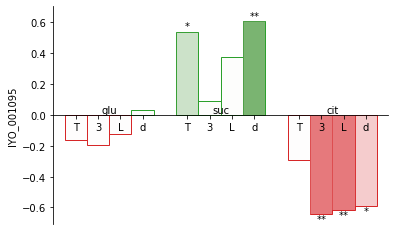

In [27]:
def one_barplot(row, pval=None, ax=None, title=None, xpos =(0,1,2,3,5,6,7,8,10,11,12,13)
):
    """Barplot for one gene locus. """
    assert all(row.index == pval.index)
    if ax is None:
        ax = plt.gca()
    mx = np.max(np.abs(row[row<np.inf]))
    for x,y,p in zip(xpos,row, pval):
        va = 'top' if y<0 else 'bottom'
        if p<0.01:
            plt.text(x,y,'**', verticalalignment=va, horizontalalignment='center')
        elif p<0.05:
            plt.text(x,y,'*', verticalalignment=va, horizontalalignment='center')
    
    def alpha(p):
        return 0.8 if p<0.01 else (0.3 if p<0.05 else 0.01)
    
    ax.bar(xpos, 
          row,
            fc='none',
            width=1,
            ec=['C2' if x>0 else 'C3' for x in row])
    ax.bar(xpos, 
           row,
           width=1,
           color=[ (89/255,161/255,78/255,alpha(p)) if x>0
                   else (224/255,88/255,91/255, alpha(p))
                  for x,p in zip(row,pval)],
           )
    ax.set_ylim(-1.1*mx,1.1*mx)
    ax.set_xlim(-1,14)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    if title:
        ax.set(ylabel=title)
    if title is not False:
        ax.set(ylabel=row.name)
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')

    ax.yaxis.set_ticks_position('left')
    ax.set_xticks(xpos)
    ax.set_xticklabels([x.split('_')[0][1:2] for x in row.index],
                       rotation=90)
    for s,x in zip([x.split('_')[1][:3] for x in row.index[::4]],
                   [x+0.5 for x in xpos[1::4]]):
        ax.text(x,0,s, verticalalignment='bottom', horizontalalignment='center')
    ax.spines['bottom'].set_position('center')
    
def several_barplots(data, iyo_list, pval):
    iyo_list = [x for x in iyo_list if x in data.index]
    N = len(iyo_list)
    if N:
        fig, ax = plt.subplots(N,1,figsize=(3,2*N))
        if N>1:
            for a,key in zip(ax,iyo_list):
                one_barplot(data.loc[key], pval.loc[key],a)
        else:
            one_barplot(data.loc[iyo_list[0]], pval.loc[iyo_list[0]],ax)
        return fig,ax
    else:
        return None,None
    
one_barplot(data.loc['IYO_001095'], pval.loc['IYO_001095'])

In [28]:
# Parse the Kegg pathway files and filter the ones that appear in the database. 
pathways = [os.path.basename(x).split('.')[0] for x in glob.glob(KEGG_PATHWAYS_GLOB)]
logger.info('Loaded {} KEGG pathways from {}'.format(len(pathways), KEGG_PATHWAYS_GLOB))

index_iyo = {}
titles = {}
images = {}
links = {}
for pathway in pathways:
    index_iyo[pathway] = []
    title, image, link, ks = parse_keggmap('data/kegg/maps/{}.xml'.format(pathway))
    titles[pathway] = title
    images[pathway] = image
    links[pathway] = link

    for k in ks:
        if k in ko_to_iyo:
            for iyo in ko_to_iyo[k]:
                if iyo in data.index:
                    index_iyo[pathway].append(iyo)
    if not index_iyo[pathway]:
        del index_iyo[pathway]
    else:
        index_iyo[pathway] = list(sorted(frozenset(index_iyo[pathway]), key=lambda x:int(x.split('_')[1])))
        
pathways_index = pd.read_csv('data/kegg/maps/index.csv')
pathways_index['map'] = [x[1:] for x in pathways_index['map']]
set_pathways = frozenset([x for x in index_iyo.keys()])
pathways_index = pathways_index[[x in set_pathways for x in pathways_index['map']]]
pathways_index['name'] = [titles[pathway] for pathway in pathways_index['map']]
pathways_index['link'] = [links[pathway] for pathway in pathways_index['map']]
pathways_index['images'] = [images[pathway] for pathway in pathways_index['map']]

logger.info("{}/{} Kegg pathways have differentially expressed genes".format(len(index_iyo),len(pathways)))
pathways_index.groupby(['title','subtitle']).count()

INFO: Loaded 454 KEGG pathways from data/kegg/maps/*.xml
INFO: 248/454 Kegg pathways have differentially expressed genes


id0  \
title                                subtitle                                           
Cellular Processes                   Cell growth and death                         11   
                                     Cell motility                                  2   
                                     Transport and catabolism                       2   
Environmental Information Processing Membrane transport                             3   
                                     Signal transduction                           13   
Genetic Information Processing       Replication and repair                         7   
                                     Transcription                                  1   
                                     Translation                                    8   
Human Diseases                       Cardiovascular disease                         2   
                                     Endocrine and metabolic disease               32   
                                     Environmental adaptation                      12   
                                     Immune disease                                 1   
                                     Neurodegenerative disease                      6   
                                     Substance dependence                           3   
Metabolism                           Amino acid metabolism                         14   
                                     Biosynthesis of other secondary metabolites   15   
                                     Carbohydrate metabolism                       15   
                                     Energy metabolism                              7   
                                     Global and overview maps                       9   
                                     Glycan biosynthesis and metabolism             3   
                                     Lipid metabolism                               9   
                                     Metabolism of cofactors and vitamins          12   
                                     Metabolism of other amino acids                8   
                                     Metabolism of terpenoids and polyketides       8   
                                     Nucleotide metabolism                          2   
                                     Xenobiotics biodegradation and metabolism     17   
Organismal Systems                   Aging                                          3   
                                     Endocrine system                              10   
                                     Environmental adaptation                       2   
                                     Excretory system                               1   
                                     Immune system                                  5   
                                     Nervous system                                 5   

                                                                                  id1  \
title                                subtitle                                           
Cellular Processes                   Cell growth and death                         11   
                                     Cell motility                                  2   
                                     Transport and catabolism                       2   
Environmental Information Processing Membrane transport                             3   
                                     Signal transduction                           13   
Genetic Information Processing       Replication and repair                         7   
                                     Transcription                                  1   
                                     Translation                                    8   
Human Diseases                       Cardiovascular disease                         2   
                                     Endocrine and metabolic disease        

In [29]:
# Write the KEGG mapping index. 
with open(os.path.join(KEGG_HTML_OUTPUT,'index.html'),'w') as file:
    file.write(head)
    file.write('<h1>Kegg Pathways</h1>')
    file.write('<p>These table show the average effect on the genes associated to the pathway. Click for details.<p>')
    for ti,gr_title in sorted(pathways_index.groupby(['title','id0']), key=lambda x:x[0][1]):
        file.write('<h2>{0[1]}. {0[0]}</h2>'.format(ti))
        for subtitle,v in sorted(gr_title.groupby(['subtitle','id1']), key=lambda x:x[0][1]):
            file.write('\n\n<h3>{0[1]}.{1} {0[0]}</h3>'.format(subtitle, ti[1]))
            file.write("<table>")
            file.write('\n'.join(header_table_html(data.columns,['pathway','genes'])))
            for pathway,row in v.set_index('map').iterrows():
                idx = index_iyo[pathway]
                file.write('<tr><td><a href="{}.html">{}</a> </td>'.format(pathway, row['name']))
                file.write('<td> {} </td>\n'.format(len(idx)))
                file.write(row_html(pathway,data.loc[[i for i in idx if i in data.index],:].mean(),data.columns,pval_dset=None))
                file.write('</tr>\n'.format(len(idx)))
            file.write("</table>")
    file.write(foot)

In [30]:
index_iyo

{'01130': ['IYO_000310',
  'IYO_000365',
  'IYO_000370',
  'IYO_000535',
  'IYO_000730',
  'IYO_000735',
  'IYO_000890',
  'IYO_000995',
  'IYO_001010',
  'IYO_001015',
  'IYO_001085',
  'IYO_001185',
  'IYO_001690',
  'IYO_001755',
  'IYO_001835',
  'IYO_001840',
  'IYO_001995',
  'IYO_002145',
  'IYO_002150',
  'IYO_002155',
  'IYO_002170',
  'IYO_002395',
  'IYO_002400',
  'IYO_002405',
  'IYO_002540',
  'IYO_002545',
  'IYO_002550',
  'IYO_002600',
  'IYO_002995',
  'IYO_003100',
  'IYO_003105',
  'IYO_003285',
  'IYO_003800',
  'IYO_003830',
  'IYO_004025',
  'IYO_004130',
  'IYO_004435',
  'IYO_004545',
  'IYO_004550',
  'IYO_004715',
  'IYO_004720',
  'IYO_004745',
  'IYO_004750',
  'IYO_004755',
  'IYO_004870',
  'IYO_004920',
  'IYO_005335',
  'IYO_005375',
  'IYO_005545',
  'IYO_006015',
  'IYO_006220',
  'IYO_006225',
  'IYO_006230',
  'IYO_006340',
  'IYO_006390',
  'IYO_006400',
  'IYO_006405',
  'IYO_006545',
  'IYO_006560',
  'IYO_006615',
  'IYO_006995',
  'IYO_007050',

In [31]:
style = '''<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<vizmap id="VizMap-2020_01_27-14_09" documentVersion="3.0">
    <visualStyle name="kegg_custom_rnaseq_exported">
        <network>
            <visualProperty default="550.0" name="NETWORK_WIDTH"/>
            <visualProperty default="0.0" name="NETWORK_CENTER_Z_LOCATION"/>
            <visualProperty default="true" name="NETWORK_NODE_SELECTION"/>
            <visualProperty default="1.0" name="NETWORK_SCALE_FACTOR"/>
            <visualProperty default="0.0" name="NETWORK_DEPTH"/>
            <visualProperty default="400.0" name="NETWORK_HEIGHT"/>
            <visualProperty default="false" name="NETWORK_ANNOTATION_SELECTION"/>
            <visualProperty default="" name="NETWORK_TITLE"/>
            <visualProperty default="0.0" name="NETWORK_CENTER_X_LOCATION"/>
            <visualProperty default="0.0" name="NETWORK_CENTER_Y_LOCATION"/>
            <visualProperty default="550.0" name="NETWORK_SIZE"/>
            <visualProperty default="true" name="NETWORK_EDGE_SELECTION"/>
            <visualProperty default="#FFFFFF" name="NETWORK_BACKGROUND_PAINT"/>
        </network>
        <node>
            <dependency value="false" name="nodeCustomGraphicsSizeSync"/>
            <dependency value="false" name="nodeSizeLocked"/>
            <visualProperty default="#000000" name="NODE_LABEL_COLOR">
                <passthroughMapping attributeName="KEGG_NODE_LABEL_COLOR" attributeType="string"/>
            </visualProperty>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_LABEL_POSITION">
                <discreteMapping attributeName="KEGG_NODE_TYPE" attributeType="string">
                    <discreteMappingEntry attributeValue="compound" value="S,N,c,0.00,2.00"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="ELLIPSE" name="NODE_SHAPE">
                <discreteMapping attributeName="KEGG_NODE_TYPE" attributeType="string">
                    <discreteMappingEntry attributeValue="ortholog" value="RECTANGLE"/>
                    <discreteMappingEntry attributeValue="gene" value="RECTANGLE"/>
                    <discreteMappingEntry attributeValue="map" value="ROUND_RECTANGLE"/>
                    <discreteMappingEntry attributeValue="compound" value="ELLIPSE"/>
                    <discreteMappingEntry attributeValue="group" value="RECTANGLE"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_9"/>
            <visualProperty default="#0066BB" name="NODE_FILL_COLOR">
                <passthroughMapping attributeName="KEGG_NODE_FILL_COLOR" attributeType="string"/>
            </visualProperty>
            <visualProperty default="0.0" name="NODE_Z_LOCATION"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_7"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_4"/>
            <visualProperty default="false" name="NODE_SELECTED"/>
            <visualProperty default="" name="NODE_TOOLTIP">
                <passthroughMapping attributeName="KEGG_NODE_LABEL" attributeType="string"/>
            </visualProperty>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_7"/>
            <visualProperty default="N,S,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_1"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_7"/>
            <visualProperty default="240" name="NODE_TRANSPARENCY">
                <discreteMapping attributeName="KEGG_NODE_TYPE" attributeType="string">
                    <discreteMappingEntry attributeValue="group" value="0"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_8"/>
            <visualProperty default="ROUND_RECTANGLE" name="COMPOUND_NODE_SHAPE"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_6"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_5"/>
            <visualProperty default="0.0" name="NODE_X_LOCATION">
                <passthroughMapping attributeName="KEGG_NODE_X" attributeType="string"/>
            </visualProperty>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_6"/>
            <visualProperty default="Dialog.plain,plain,12" name="NODE_LABEL_FONT_FACE"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_3"/>
            <visualProperty default="true" name="NODE_VISIBLE"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_1">
                <passthroughMapping attributeName="graph" attributeType="string"/>
            </visualProperty>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_5"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_8"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_5, name=Node Custom Paint 5)" name="NODE_CUSTOMPAINT_5"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_6"/>
            <visualProperty default="#000000" name="NODE_BORDER_PAINT"/>
            <visualProperty default="10.0" name="COMPOUND_NODE_PADDING"/>
            <visualProperty default="255" name="NODE_LABEL_TRANSPARENCY"/>
            <visualProperty default="70.0" name="NODE_SIZE"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_2"/>
            <visualProperty default="8" name="NODE_LABEL_FONT_SIZE">
                <discreteMapping attributeName="KEGG_NODE_TYPE" attributeType="string">
                    <discreteMappingEntry attributeValue="ortholog" value="9"/>
                    <discreteMappingEntry attributeValue="gene" value="9"/>
                    <discreteMappingEntry attributeValue="compound" value="6"/>
                    <discreteMappingEntry attributeValue="map" value="9"/>
                    <discreteMappingEntry attributeValue="group" value="9"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_8, name=Node Custom Paint 8)" name="NODE_CUSTOMPAINT_8"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_3"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_2, name=Node Custom Paint 2)" name="NODE_CUSTOMPAINT_2"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_3"/>
            <visualProperty default="0.0" name="NODE_BORDER_WIDTH">
                <discreteMapping attributeName="KEGG_NODE_TYPE" attributeType="string">
                    <discreteMappingEntry attributeValue="ortholog" value="1.0"/>
                    <discreteMappingEntry attributeValue="compound" value="2.0"/>
                    <discreteMappingEntry attributeValue="group" value="1.0"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="SOLID" name="NODE_BORDER_STROKE"/>
            <visualProperty default="80.0" name="NODE_CUSTOMGRAPHICS_SIZE_1"/>
            <visualProperty default="0.0" name="NODE_Y_LOCATION">
                <passthroughMapping attributeName="KEGG_NODE_Y" attributeType="string"/>
            </visualProperty>
            <visualProperty default="#787878" name="NODE_PAINT"/>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_9"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_2"/>
            <visualProperty default="70.0" name="NODE_HEIGHT">
                <passthroughMapping attributeName="KEGG_NODE_HEIGHT" attributeType="string"/>
            </visualProperty>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_7, name=Node Custom Paint 7)" name="NODE_CUSTOMPAINT_7"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_6, name=Node Custom Paint 6)" name="NODE_CUSTOMPAINT_6"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_5"/>
            <visualProperty default="255" name="NODE_BORDER_TRANSPARENCY"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_1, name=Node Custom Paint 1)" name="NODE_CUSTOMPAINT_1"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_9, name=Node Custom Paint 9)" name="NODE_CUSTOMPAINT_9"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_4, name=Node Custom Paint 4)" name="NODE_CUSTOMPAINT_4"/>
            <visualProperty default="" name="NODE_LABEL">
                <passthroughMapping attributeName="KEGG_NODE_LABEL_LIST_FIRST" attributeType="string"/>
            </visualProperty>
            <visualProperty default="70.0" name="NODE_WIDTH">
                <passthroughMapping attributeName="KEGG_NODE_WIDTH" attributeType="string"/>
            </visualProperty>
            <visualProperty default="0.0" name="NODE_CUSTOMGRAPHICS_SIZE_4"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_9"/>
            <visualProperty default="#FFFF00" name="NODE_SELECTED_PAINT"/>
            <visualProperty default="0.0" name="NODE_DEPTH"/>
            <visualProperty default="org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ]," name="NODE_CUSTOMGRAPHICS_2"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_4"/>
            <visualProperty default="true" name="NODE_NESTED_NETWORK_IMAGE_VISIBLE"/>
            <visualProperty default="C,C,c,0.00,0.00" name="NODE_CUSTOMGRAPHICS_POSITION_8"/>
            <visualProperty default="110.0" name="NODE_LABEL_WIDTH"/>
            <visualProperty default="DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_3, name=Node Custom Paint 3)" name="NODE_CUSTOMPAINT_3"/>
        </node>
        <edge>
            <dependency value="false" name="arrowColorMatchesEdge"/>
            <visualProperty default="180" name="EDGE_TRANSPARENCY"/>
            <visualProperty default="#DC143C" name="EDGE_LABEL_COLOR"/>
            <visualProperty default="#404040" name="EDGE_UNSELECTED_PAINT">
                <passthroughMapping attributeName="KEGG_EDGE_COLOR" attributeType="string"/>
            </visualProperty>
            <visualProperty default="" name="EDGE_BEND"/>
            <visualProperty default="true" name="EDGE_CURVED"/>
            <visualProperty default="NONE" name="EDGE_TARGET_ARROW_SHAPE">
                <discreteMapping attributeName="KEGG_EDGE_SUBTYPES" attributeType="string">
                    <discreteMappingEntry attributeValue="expression" value="ARROW"/>
                    <discreteMappingEntry attributeValue="indirect effect" value="HALF_TOP"/>
                    <discreteMappingEntry attributeValue="irreversible" value="ARROW"/>
                    <discreteMappingEntry attributeValue="inhibition" value="T"/>
                    <discreteMappingEntry attributeValue="repression" value="T"/>
                    <discreteMappingEntry attributeValue="activation" value="ARROW"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="#FFFF00" name="EDGE_SOURCE_ARROW_SELECTED_PAINT"/>
            <visualProperty default="#000000" name="EDGE_TARGET_ARROW_UNSELECTED_PAINT"/>
            <visualProperty default="1.0" name="EDGE_WIDTH"/>
            <visualProperty default="Dialog.plain,plain,12" name="EDGE_LABEL_FONT_FACE"/>
            <visualProperty default="10" name="EDGE_LABEL_FONT_SIZE"/>
            <visualProperty default="#000000" name="EDGE_SOURCE_ARROW_UNSELECTED_PAINT"/>
            <visualProperty default="#FF0000" name="EDGE_SELECTED_PAINT"/>
            <visualProperty default="6.0" name="EDGE_TARGET_ARROW_SIZE"/>
            <visualProperty default="6.0" name="EDGE_SOURCE_ARROW_SIZE"/>
            <visualProperty default="200.0" name="EDGE_LABEL_WIDTH"/>
            <visualProperty default="#FF0000" name="EDGE_STROKE_SELECTED_PAINT"/>
            <visualProperty default="255" name="EDGE_LABEL_TRANSPARENCY"/>
            <visualProperty default="NONE" name="EDGE_SOURCE_ARROW_SHAPE"/>
            <visualProperty default="#404040" name="EDGE_STROKE_UNSELECTED_PAINT"/>
            <visualProperty default="SOLID" name="EDGE_LINE_TYPE">
                <discreteMapping attributeName="KEGG_EDGE_SUBTYPES" attributeType="string">
                    <discreteMappingEntry attributeValue="state change" value="DOT"/>
                    <discreteMappingEntry attributeValue="indirect effect" value="LONG_DASH"/>
                    <discreteMappingEntry attributeValue="binding/association" value="LONG_DASH"/>
                    <discreteMappingEntry attributeValue="maplink" value="LONG_DASH"/>
                </discreteMapping>
            </visualProperty>
            <visualProperty default="#FFFF00" name="EDGE_TARGET_ARROW_SELECTED_PAINT"/>
            <visualProperty default="false" name="EDGE_SELECTED"/>
            <visualProperty default="" name="EDGE_TOOLTIP"/>
            <visualProperty default="#808080" name="EDGE_PAINT"/>
            <visualProperty default="" name="EDGE_LABEL">
                <passthroughMapping attributeName="KEGG_EDGE_LABEL" attributeType="string"/>
            </visualProperty>
            <visualProperty default="true" name="EDGE_VISIBLE"/>
        </edge>
    </visualStyle>
</vizmap>'''
with open('kegg_style.xml', 'w') as file:
    file.write(style)

In [39]:
cy = CyRestClient()
cyclient = cyrest.cyclient()
cy.session.delete()

In [40]:
# Use Cytoscape to draw SVG of all the pathways, integrating barplots drawn with matplotlib (LOONG). 
# Cytokegg is required https://apps.cytoscape.org/apps/cytokegg
# It also require that the small graphs are served on localhost so cytoscape find them (python3 -m http.server 8012 in the right folder). I know. 
table_node = {}
def small_graph_path(x):
    p = os.path.join(KEGG_HTML_OUTPUT, 'graphs', '{}.png'.format(x.replace(':','_')))
    if os.path.exists(p):
        return LOCALHOST+p

for pathway,_ in index_iyo.items():
    print(pathway)
    try:
        
        # Load the pathway. 
        net = cy.network.create_from('data/kegg/maps/{}.xml'.format(pathway))
        table = net.get_node_table()
        
        # Get the gene locus associated with a given node. 
        node_to_iyo = defaultdict(lambda:[])
        for key,row in table.iterrows():
            try:
                ks = [re.findall('(K[0-9]{5})', k)[0] for k in row.KEGG_ID if 'K' in k]
            except TypeError:
                ks = []
            for k in ks:
                if k in ko_to_iyo:
                    for iyo in ko_to_iyo[k]:
                        node_to_iyo[row['name']].append(iyo)
                        
        # Create barplots.
        for k,v in node_to_iyo.items():
            fname = os.path.join(KEGG_HTML_OUTPUT, 'graphs','{}.png'.format(k.replace(':','_')))
            if not os.path.exists(fname):
                fig, ax = several_barplots(data, v, pval)
                if fig:
                    fig.savefig(fname,
                                bbox_inches='tight',
                                transparent=True)
                plt.close()

        # Add columns to the table node in cytoscape. 
        table['graph'] = [small_graph_path(x) for x in table['name']]
        table['KEGG_NODE_FILL_COLOR_BACK'] = table['KEGG_NODE_FILL_COLOR']
        table['KEGG_NODE_FILL_COLOR'] = ['#edc958' if g else x for x,g in zip(table['KEGG_NODE_FILL_COLOR'], 
                                                                              table['graph'])]
        
        # Save & update the table. 
        table.to_csv('cyto/{}.csv'.format(pathway))
        table_node[pathway] = table.copy()
        net.update_node_table(df=table, network_key_col="SUID", data_key_col="SUID")

        
        #cyclient.apply.applyStyle(styleName="kegg_rnaseq", networkId=str(net.get_id()))
        cyclient.vizmap.load_file(os.path.abspath("kegg_style.xml"), verbose=False)
        

        cyclient.apply.applyStyle("kegg_custom_rnaseq_exported", networkId=str(net.get_id()))
    
        cyclient.view.fit_content()
        cyclient.view.update()
        # Export view as svg
        
        path = os.path.abspath(os.path.join(KEGG_HTML_OUTPUT, 'pathway_{}.svg'.format(pathway)))
        if os.path.exists(path):
            os.remove(path)
        cyclient.view.export(Height=4000, options='svg', outputFile=path)
        
    except Exception as ex:
        print(ex)
        raise ex

01130
05211
02060
05225
00590
03008
01055
05130
04910
04216
02040
01220
00500
04940
04146
00830
00791
05168
04934
00960
00592
05133
00680
00622
00281
05340
05203
05131
00710
00950
00311
04659
00965
00860
04931
04919
03060
04210
04728
00523
00627
04932
04914
04215
00940
00410
04211
00642
01040
05206
03030
04068
00900
01210
00290
04666
05150
00550
00521
05161
00361
01503
00770
05163
05210
00051
05014
02020
03440
00195
05152
04714
05160
00040
05170
04014
04915
00430
01502
04115
01523
00020
00280
00531
05017
00998
04214
00785
00620
00130
00405
04071
00300
00362
00061
05169
00230
00350
03010
00072
00630
04626
00903
01212
00750
00220
00561
00562
05416
05212
00540
00997
00440
05020
00052
00332
00340
01200
00660
02010
04072
00670
05135
04011
00780
00908
01110
01501
00910
05231
02025
00261
02026
03410
03020
05120
00970
03450
00480
00966
04918
05031
03320
03420
00980
05111
00333
04723
04612
00624
00330
04928
02030
00740
03460
05016
00920
04930
04013
05164
00460
05204
03430
00640
04657
01051
0501

In [34]:
%load_ext autoreload
%autoreload 2

In [35]:
def describe_html(label, row):
    graph = row.graph
    ks = frozenset(re.findall('(K[0-9]{5})', str(row.KEGG_ID)))
    out = []
    for k in ks:
        if k in kegg_data:
            out.append('<strong>{}</strong><br/>'.format(kegg_data[k]['DEFINITION']))
            if k in ko_to_iyo:
                out.append('Genes:<ul>')
                for iyo in ko_to_iyo[k]:
                    if iyo in pseudo.index:
                        gene = pseudo.loc[iyo]
                        out.append('<li><a href="http://pseudomonas.com/feature/show?id={}">{}</a>: {}</li>'.format(gene['PGD Gene ID'].replace('PGD',''),
                                                                                                                    iyo,
                                                                                                                    gene['Product Name'] ))
                    else:
                        out.append('<li>{}</li>'.format(iyo))
                out.append('</ul>')
    if graph:
        out.append('<br/><img src="{}"/><br/>'.format(graph.replace(LOCALHOST + KEGG_HTML_OUTPUT+'/','')))
    out.append('<a href="{}">See on KEGG</a>'.format(row.KEGG_LINK))
    return '\n'.join(out)

In [36]:
if not os.path.exists(os.path.join(KEGG_HTML_OUTPUT,'lib')):
    os.mkdir(os.path.join(KEGG_HTML_OUTPUT,'lib'))
if not os.path.exists(PAN_ZOOM_LOCAL):
    urllib.request.urlretrieve(PAN_ZOOM_URL,PAN_ZOOM_LOCAL)
with open(os.path.join(KEGG_HTML_OUTPUT,'lib','svg-pan-zoom.min.js'),'w') as file:
    file.write(open(PAN_ZOOM_LOCAL,'r').read())

In [37]:
# Write a webpage per kegg pathway. 
for pathway,row in pathways_index.set_index('map').iterrows():
    
    with open(os.path.join(KEGG_HTML_OUTPUT,'{}.html'.format(pathway)),'w') as file:
        file.write(head)
        file.write('<h1>{} <a href="{}" style="color:black;opacity:0.3;text-decoration:none">&#128279;</a></h1> '.format(row['name'], row['link']))
        file.write('''<div style="width:20%;float:right; border:1px solid black" id="tooltip">
        Pathway is loading...</div>''')
        file.write('<object id="network" style="width:79%;border:1px solid black" type="image/svg+xml" data="pathway_{}.svg"></object>'.format(pathway))
        file.write(("""<script>
        document.getElementById('network').addEventListener('load', function(){
          var kegg_desc =  """ 
                    + json.dumps({k:describe_html(k,r) for k,r in table_node[pathway].set_index('KEGG_NODE_LABEL').iterrows()})
          + """
          tooltip = document.getElementById('tooltip')
          tooltip.innerHTML = 'Hover a node for details'
          let pan = svgPanZoom(document.getElementById('network'), {controlIconsEnabled: true})
          pan.resize()
          pan.fit()
          pan.center()
          let svg = document.querySelectorAll('#network')[0].contentDocument;
          var elements = Array.from(svg.querySelectorAll('text'));
          function start(e){
          let node = e.target.innerHTML
          out = '<strong>'+node+'</strong></br>' 
          // out += (node in path_graph ? "<img src="+path_graph[node]+">" : "")
          out += kegg_desc[node]
          tooltip.innerHTML = out
          console.log(e.target.innerHTML)} 
             elements.forEach(function(el) { el.addEventListener("mouseover",  start); })
        })
        </script>"""))
        file.write(table_html(data.loc[[i for i in index_iyo[pathway] if i in data.index],:]))
        file.write('<a href="{}">See pathway on KEGG</a>'.format(row['link']))
        file.write(foot)

---

In [38]:
# Index page. 
info = """<table style="border:1px solid black">
<tr><th></th><th>MCP,meR,enolase...</th><th>dctT</th><th>lysR</th><th>cata/lipo</th></tr>
<tr><th>Tn6212</th><td></td><td></td><td></td><td></td>
<tr><th>Δ3</th><td>X</td><td>X</td><td></td><td></td>
<tr><th>ΔlysR</th><td>X</td><td>X</td><td></td><td>X</td>
<tr><th>ΔdctT</th><td>X</td><td></td><td>X</td><td>X</td>
</table>
"""
index_head = """<!DOCTYPE html>
<html>
<meta charset="utf-8" />
<title> Psa RNAseq </title>
<body>
<h1>Psa RNAseq</h1>
"""+info
index_content = '<ul>{}</ul>'.format('\n'.join(['<li><a href="{}">{}</a> (<a href="{}">csv</a>)</li>'.format(url,title,url.replace('html','csv')) for url,title in datasets]))
index_content += '<ul><li><a href="kegg.html">Kegg hierarchy (Only genes that are mapped are show, genes can appear in several categories)</a></li>'
index_content += '<li><a href="kegg/">Kegg Pathways</a></li></ul>'
#index_content += '<a href="position.png"><img src="position.png"/></a>'
index_content += '<pre>{}</pre>'.format(open('rnaseq.log','r').read())
index_foot = '</body></html>'
index = index_head + index_content + index_foot


with open('www/index.html','w') as file:
    file.write(index)
HTML(index.replace('href="','href="www/'))